# Overview and Notes

What are interesting scenarios for exploring correlations?
* Expression-dependency correlations for dependency genes that are druggable. For these, the expression correlates are informative for selection of sensitive cell lines/patients. In addition, causally related expression correlates are suggestive of possible resistance mechanisms or secondary targets for a drug combination.
* Dependency-dependency correlations for undruggable genes. For these, the correlates are suggestive of substitute targets, or combinations of targets. However, as combinations are considered the causal interpretation becomes more important.
* Expression-expression correlations. In this case one idea would be to explore the strength and sign of relationships from the data vs. assertions from curated databases/literature, particularly from perturbational experiments.
* Co-expression patterns. Another possibility is to discover patterns of relationships between genes, e.g. that expression of ubiquitin ligases is correlated with the expression of their targets.

Another interesting direction would be to use the information in the INDRA database to discover patterns of mechanistic relationships that predict correlations between dependencies of two genes, or between expression of a gene and dependency of another gene. The simplest possible application of this would be to look at pairwise relationships between two genes (could even extract from SIF), and test to see which types of relationships, and signs of relationships predicted, and amount of evidence predicted a) the sign of a correlation and b) the strength of the correlation.

If the matrix is made complete, i.e., if entries are included for having no known relationship, we may find that having no relationship is not predictive of a lack of a correlation.

Similarly, there will be many mechanistic relationships that yield detectable correlations.

One hypothesis that could be tested is whether downstream siblings were more likely to have large correlations to each other than with their ancestors, highlighting that correlations rarely pick up causal relations in this type of data.

Could do this with graph convolutional nets?

Another application would be to use the data to refine vague relationships extracted from text, or to address issues with assembly, a la distant supervision.

Another direction would be to cluster the correlation graph to find likely intermediates.

Or, to use the redundancy of certain gene families to explain why certain correlations do *not* show up, i.e., the gene knockout has no effect because it has a redundant copy.

# Preliminaries

In [1]:
import pickle
from os.path import join, expanduser
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from indra.databases import hgnc_client
from indra.util import plot_formatting as pf
from indra.tools import assemble_corpus as ac

from depmap_analysis.scripts.depmap_script2 import main as run_depmap
from depmap_analysis.scripts.depmap_script2 import mito_file
from depmap_analysis.preprocessing import get_mitocarta_info
from depmap_analysis.network_functions.depmap_network_functions import corr_matrix_to_generator

from scipy.stats import linregress

%matplotlib notebook

INFO: [2021-03-22 16:53:06] pybel.config - no configuration found, using default sqlite connection sqlite:////Users/johnbachman/.pybel/pybel_0.14.0_cache.db
INFO: [2021-03-22 16:53:08] indra.ontology.bio.ontology - Loading INDRA bio ontology from cache at /Users/johnbachman/.indra/bio_ontology/1.7/bio_ontology.pkl

(Background on this error at: http://sqlalche.me/e/e3q8)


## Load transcript and dependency data and compute correlations


Key variables/functions:
* `ccle_df`. CCLE expression data, DataFrame.
* `crispr_df`. DepMap CRISPR gene effect (dependency) data, DataFrame.
* `crispr_corr`
* `crispr_z`
* `rnai_df`. DepMap combined RNAi data, DataFrame.
* `rna_corr`
* `rnai_z`
* `dep_z`
* `dep_df`. CRISPR and RNAi data combined as averaged z-scores, DataFrame.
* `dep_corr`. Correlation matrix between dep-dep, dep-expr, and expr-expr (though expr-expr correlations are only defined in this matrix for the genes also included in the dependency data).

### Working directory

In [2]:
#basedir = 'data/20q4'
basedir = '/Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/depmap/21q1'
figdir = join(expanduser('~'), 'Dropbox/DARPA projects/papers/INDRA paper 2/figures/figure_panels')

### Cell line metadata

Load the cell line metadata which includes mappings between cell line identifiers used by different datasets.

In [3]:
cell_line_df = pd.read_csv(join(basedir, 'sample_info.csv'))
#cell_line_df = pd.read_csv('data/DepMap-2019q1-celllines_v2.csv')

In [4]:
cell_line_map = cell_line_df[['DepMap_ID', 'CCLE_Name']]
cell_line_map.set_index('CCLE_Name', inplace=True)
cell_line_map.head()

,DepMap_ID
CCLE_Name,
NIHOVCAR3_OVARY,ACH-000001
HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000002
CACO2_LARGE_INTESTINE,ACH-000003
HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000004
HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000005


### RNAi data

Load combined RNAi data, normalize column names, map to DepMap cell line IDs, and drop duplicate columns.

In [5]:
%time rnai_df = pd.read_csv(join(basedir, 'D2_combined_gene_dep_scores.csv'), index_col=0)
rnai_df = rnai_df.transpose()
gene_cols = ['%s' % col.split(' ')[0] for col in rnai_df.columns]
rnai_df.columns = gene_cols
rnai_df = rnai_df.join(cell_line_map)
rnai_df = rnai_df.set_index('DepMap_ID')
# Drop duplicate columns
rnai_df = rnai_df.loc[:,~rnai_df.columns.duplicated()]

CPU times: user 2.02 s, sys: 199 ms, total: 2.22 s
Wall time: 2.25 s


In [6]:
rnai_df.head()

,A1BG,NAT2,ADA,CDH2,AKT3,MED6,NR2E3,NAALAD2,DUXB,PDZK1P1,...,RCE1,HNRNPDL,DMTF1,PPP4R1,CDH1,SLC12A6,KCNE2,DGCR2,CASP8AP2,SCO2
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-001270,NaN,NaN,NaN,-0.194962,-0.256108,-0.174220,-0.140052,NaN,NaN,NaN,...,-0.201644,-0.363670,0.184260,-0.115616,-0.125958,NaN,0.088853,NaN,-0.843295,NaN
ACH-001000,NaN,NaN,NaN,-0.028171,0.100751,-0.456124,-0.174618,NaN,NaN,NaN,...,0.074889,0.152158,0.036011,0.117300,0.101725,NaN,-0.110628,NaN,-0.307031,NaN
ACH-001001,0.146042,0.102854,0.168839,0.063047,-0.008077,-0.214376,-0.153619,0.133830,0.138673,0.030345,...,0.006735,-0.033385,0.197651,-0.016372,0.077486,0.106165,0.057286,0.025596,-0.413669,0.122669
ACH-002319,-0.190388,0.384106,-0.120700,-0.237251,0.060267,-0.338946,-0.057551,0.134511,NaN,0.144463,...,0.209009,-0.156839,-0.155837,-0.001141,NaN,0.227968,0.028095,-0.080611,-1.849696,-0.078856
ACH-001827,0.907063,0.403192,0.004394,-0.017059,-0.094749,-0.328074,-0.089573,0.362029,NaN,-0.098161,...,-0.137465,-1.037848,-0.261262,-0.228016,NaN,0.088744,0.159467,0.014071,-0.414154,0.032661


In [7]:
recalculate = False
filename = 'rnai_correlations'
filepath = join(basedir, filename)
if recalculate:
    %time rnai_corr = rnai_df.corr()
    rnai_corr.to_hdf('%s.h5' % filepath, filename)
else:
    rnai_corr = pd.read_hdf('%s.h5' % filepath)

INFO: [2021-03-22 16:53:21] numexpr.utils - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: [2021-03-22 16:53:21] numexpr.utils - NumExpr defaulting to 8 threads.


In [8]:
rnai_mean = rnai_corr.values.mean()
rnai_sd = rnai_corr.values.std()
rnai_z = (rnai_corr - rnai_mean) / rnai_sd

In [9]:
rnai_z.head()

,A1BG,NAT2,ADA,CDH2,AKT3,MED6,NR2E3,NAALAD2,DUXB,PDZK1P1,...,RCE1,HNRNPDL,DMTF1,PPP4R1,CDH1,SLC12A6,KCNE2,DGCR2,CASP8AP2,SCO2
A1BG,12.735562,-0.770498,-0.828444,0.593730,-0.334519,-0.076705,1.054949,0.591804,0.385034,-0.120219,...,1.446480,-1.964996,-0.403560,0.402625,-0.396057,0.131028,0.227373,-0.701314,0.218191,1.198913
NAT2,-0.770498,12.735562,0.572062,-0.052426,-0.528069,0.307443,-0.021474,-0.590996,-0.318764,-1.449979,...,0.371740,-0.754718,0.017751,0.024919,-2.128375,-0.190518,0.608389,-0.842078,-1.303389,-0.503340
ADA,-0.828444,0.572062,12.735562,-0.451619,-0.577117,0.422290,-0.188984,-0.570248,-0.078767,0.119471,...,0.475397,0.045575,0.639884,0.858577,-0.315503,-0.353140,-0.704099,1.271989,0.150168,-0.217580
CDH2,0.593730,-0.052426,-0.451619,12.735562,0.565031,-0.946426,-0.135411,0.118138,0.201983,-0.383189,...,-0.570892,-1.780034,1.163082,-1.070628,-0.127555,-0.228329,0.010906,-1.423871,-1.132664,-0.382607
AKT3,-0.334519,-0.528069,-0.577117,0.565031,12.735562,-0.378659,-1.136175,0.590426,0.837794,-0.574912,...,-1.262663,0.259384,0.443690,-0.919940,0.283450,-1.192266,-0.581840,-1.243842,-0.184748,-0.345918


### CRISPR Data

Load CRISPR dependency data and normalize column names to gene names.

In [10]:
%time crispr_df = pd.read_csv(join(basedir, 'Achilles_gene_effect.csv'), index_col=0)
gene_cols = ['%s' % col.split(' ')[0] for col in crispr_df.columns]
crispr_df.columns = gene_cols
# Drop any duplicate columns (shouldn't be any for CRISPR, but just in case)
crispr_df = crispr_df.loc[:,~crispr_df.columns.duplicated()]

CPU times: user 10.7 s, sys: 280 ms, total: 11 s
Wall time: 11.1 s


In [11]:
crispr_df.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-000004,0.164686,0.094628,-0.190746,-0.009197,0.032529,-0.191355,0.355279,-0.442430,0.298153,0.170712,...,-0.125219,-0.463670,0.031849,-0.007470,0.261947,0.237661,-0.420546,0.277953,0.227172,-0.151192
ACH-000005,-0.097058,0.241606,0.193671,0.156428,-0.195506,-0.337316,0.247947,-0.587806,-0.070959,0.004288,...,-0.212524,-0.410596,-0.180655,-0.080401,0.220940,-0.076012,-0.106125,0.068227,0.022568,-0.261572
ACH-000007,0.066212,0.073850,-0.065867,0.156038,0.100958,0.140997,0.066367,-0.472706,-0.008810,0.293417,...,-0.096162,-0.277202,-0.058930,0.108511,0.212320,-0.011173,-0.352653,0.084244,-0.387673,-0.439552
ACH-000009,0.097872,0.000361,-0.055818,0.046221,0.063069,-0.048932,0.070910,-0.640566,0.148335,0.056188,...,-0.293175,-0.259388,-0.095524,0.049911,0.072002,0.011488,-0.596006,0.189440,-0.117177,-0.539860
ACH-000011,0.270232,0.072105,0.014605,0.433243,-0.030273,-0.239080,0.097866,-0.419689,0.138635,0.106322,...,-0.401794,-0.507831,-0.136369,-0.115541,0.274140,0.154517,-0.234775,0.124355,-0.250505,-0.372498


In [12]:
# Filter out this problematic outlier stomach cell line
#crispr_df = crispr_df[crispr_df.index != 'ACH-000167']

In [13]:
recalculate = False
filename = 'crispr_correlations'
filepath = join(basedir, filename)
if recalculate:
    %time crispr_corr = crispr_df.corr()
    crispr_corr.to_hdf('%s.h5' % filepath, filename)
else:
    crispr_corr = pd.read_hdf('%s.h5' % filepath)    

In [14]:
crispr_mean = crispr_corr.values.mean()
crispr_sd = crispr_corr.values.std()
crispr_z = (crispr_corr - crispr_mean) / crispr_sd

In [15]:
crispr_z.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
A1BG,18.191784,-1.242018,1.360831,-1.011252,-0.002266,1.028501,-0.013928,0.189783,-0.111264,1.054949,...,0.266351,-0.163454,-0.612117,0.116316,-0.993662,0.847710,0.822466,0.866504,0.848916,0.824848
A1CF,-1.242018,18.191784,0.378603,-0.350676,-0.059957,-1.832413,-0.058989,0.879592,-1.663634,0.416674,...,-1.698830,-0.212665,1.627540,1.389030,-0.941134,0.047841,0.625232,-1.342363,-0.415734,0.622525
A2M,1.360831,0.378603,18.191784,1.671774,-0.456240,-1.044572,0.110470,-0.732363,0.035439,1.188912,...,-0.216869,-1.055333,-0.134216,-1.155436,0.038226,-0.533334,0.039291,-0.626993,1.098631,0.728893
A2ML1,-1.011252,-0.350676,1.671774,18.191784,-1.025899,-0.367071,-0.419824,-0.859755,-0.084455,-0.423822,...,-2.486677,-1.683715,-1.694156,-1.419016,0.350669,0.275146,0.245732,-0.222022,-0.919872,-0.640108
A3GALT2,-0.002266,-0.059957,-0.456240,-1.025899,18.191784,-0.243064,-0.702458,-1.097170,-0.273833,0.063425,...,-0.648885,-0.387377,0.292008,0.291964,-2.814227,0.775090,0.761896,-0.005202,-0.379809,1.055833


### Combine CRISPR and RNAi Z-scores

Take the average of CRISPR and RNAi z-scores and drop missing values (that arise from a gene being knocked down/out in one dataset but not the other).

In [16]:
recalculate = False
filename = 'dep_z'
z_filepath = join(basedir, '%s.h5' % filename)
if recalculate:
    %time dep_z = (crispr_z + rnai_z) / 2
    #dep_z = dep_z.dropna(axis=0, how='all').dropna(axis=1, how='all')
    dep_z.to_hdf(z_filepath, filename)
else:
    dep_z = pd.read_hdf(z_filepath)    

### Expression Data

Load the RNA-seq data (in transcripts per million, obtained from the DepMap website at https://depmap.org/portal/download/). Normalize column names (which include both gene names and Ensemble IDs) to only gene names, and then drop duplicate columns, keeping the first instance of the column for the gene name (there are 87 genes associated with more than one Ensemble ID, and these result in duplicate columns after normalizing to gene names).

In [17]:
%time ccle_df = pd.read_csv(join(basedir, 'CCLE_expression.csv'), index_col=0)

CPU times: user 17.8 s, sys: 617 ms, total: 18.4 s
Wall time: 18.6 s


In [18]:
gene_cols = ['%s' % col.split(' ')[0] for col in ccle_df.columns]
ccle_df.columns = gene_cols
# NOTE: This first way doesn't work! Probably because with duplicate column names a
# separate integer index is created after transposition (?)
#%time ccle_df_drop = ccle_df.T.drop_duplicates(keep='first').T
# See: https://stackoverflow.com/questions/14984119/python-pandas-remove-duplicate-columns
ccle_df_drop = ccle_df.loc[:,~ccle_df.columns.duplicated()]

Calculate expression correlation matrix (takes about 11 min):

In [19]:
recalculate = False
filename = 'expr_correlations'
filepath = join(basedir, filename)
if recalculate:
    %time expr_corr = ccle_df.corr()
    expr_corr.to_hdf('%s.h5' % filepath, filename)
else:
    expr_corr = pd.read_hdf('%s.h5' % filepath)    

Filter the expression data to contain only those columns also contained in the CRISPR dependency data (protein coding genes, for the most part).

In [20]:
crispr_cols = [c for c in crispr_df.columns]
# Create a boolean mask to filter the CCLE expression data columns
ccle_col_mask = np.array(ccle_df_drop.columns.map(lambda x: x in crispr_cols), dtype=bool)
ccle_df_filt = ccle_df_drop[ccle_df_drop.columns[ccle_col_mask]]

Join the two datasets on the cell line index:

In [21]:
crispr_expr_join_df = crispr_df.join(ccle_df_filt, how='left', lsuffix=' KO', rsuffix=' RNA')

Calculate the correlations (slow) or reload from HDF5.

In [22]:
recalculate = False
filename = 'crispr_expr_corr'
filepath = join(basedir, filename)
if recalculate:
    %time ce_corr = crispr_expr_join_df.corr()
    ce_corr.to_hdf('%s.h5' % filepath, filename)
else:
    ce_corr = pd.read_hdf('%s.h5' % filepath)

### Load Drug Data

In [23]:
drug_resp_df = pd.read_csv(join(basedir, 'primary-screen-replicate-collapsed-logfold-change.csv'), index_col=0)
drug_info_df = pd.read_csv(join(basedir, 'primary-screen-replicate-collapsed-treatment-info.csv'), index_col=0)

In [24]:
drug_resp_df.head()

,BRD-A00077618-236-07-6::2.5::HTS,BRD-A00100033-001-08-9::2.5::HTS,BRD-A00147595-001-01-5::2.5::HTS,BRD-A00218260-001-03-4::2.5::HTS,BRD-A00376169-001-01-6::2.5::HTS,BRD-A00520476-001-07-4::2.5::HTS,BRD-A00546892-001-02-6::2.5::HTS,BRD-A00578795-001-04-3::2.5::HTS,BRD-A00758722-001-04-9::2.5::HTS,BRD-A00827783-001-24-6::2.5::HTS,...,BRD-K98557884-001-01-6::2.5::MTS004,BRD-K99077012-001-01-9::2.332734192::MTS004,BRD-K99199077-001-16-1::2.603211317::MTS004,BRD-K99431849-001-01-7::2.500018158::MTS004,BRD-K99447003-335-04-1::2.37737659::MTS004,BRD-K99506538-001-03-8::2.5::MTS004,BRD-K99616396-001-05-1::2.499991421::MTS004,BRD-K99879819-001-02-1::2.5187366::MTS004,BRD-K99919177-001-01-3::2.5::MTS004,BRD-M63173034-001-03-6::2.64076472::MTS004
ACH-000001,-0.015577,-0.449332,0.489379,0.206675,0.272730,0.021036,-0.025460,0.467158,-0.736306,0.644137,...,0.429238,0.204841,0.150055,-0.575404,-0.101247,0.399233,-0.127658,-0.141651,-1.153652,0.510464
ACH-000007,-0.095730,0.257943,0.772349,-0.438502,-0.732832,0.779201,0.426523,-1.288508,-0.476133,-0.277105,...,-0.471486,0.212998,-0.123230,0.625527,0.383198,0.212031,0.349225,-0.387439,-0.831461,0.323558
ACH-000008,0.379480,-0.596132,0.548056,0.422269,-0.216986,0.081866,0.145335,-0.570841,-0.512119,0.452698,...,-0.111951,0.534787,0.206642,-0.410153,-0.560722,-0.036088,0.158071,0.171043,-3.947090,0.099310
ACH-000010_FAILED_STR,0.118890,-0.231615,0.621937,-0.202707,-1.005139,-0.213739,0.020246,-0.795278,NaN,0.679571,...,0.200605,-0.075356,0.610310,-0.019413,-0.202971,0.218158,-0.411009,-0.181540,-3.010225,0.090652
ACH-000011,0.145346,-0.499274,0.267470,0.157804,-0.272286,0.207768,0.004464,-0.191680,-0.310375,0.112537,...,-0.076863,0.026002,0.139921,-0.261704,0.085339,0.447482,0.164620,-0.565251,-4.110627,0.222394


Join drug sensitivity to expression on the cell line index:

In [25]:
drug_expr_df = drug_resp_df.join(ccle_df_filt, how='left')

In [26]:
drug_expr_df.head()

,BRD-A00077618-236-07-6::2.5::HTS,BRD-A00100033-001-08-9::2.5::HTS,BRD-A00147595-001-01-5::2.5::HTS,BRD-A00218260-001-03-4::2.5::HTS,BRD-A00376169-001-01-6::2.5::HTS,BRD-A00520476-001-07-4::2.5::HTS,BRD-A00546892-001-02-6::2.5::HTS,BRD-A00578795-001-04-3::2.5::HTS,BRD-A00758722-001-04-9::2.5::HTS,BRD-A00827783-001-24-6::2.5::HTS,...,SLURP2,SCO2,OR8B3,OR8B2,TMEM247,OR8S1,EEF1AKMT4,TBCE,CCDC39,ARHGAP11B
ACH-000001,-0.015577,-0.449332,0.489379,0.206675,0.272730,0.021036,-0.025460,0.467158,-0.736306,0.644137,...,0.0,1.275007,0.000000,0.0,0.0,0.056584,3.970854,5.094236,0.310340,1.545968
ACH-000007,-0.095730,0.257943,0.772349,-0.438502,-0.732832,0.779201,0.426523,-1.288508,-0.476133,-0.277105,...,0.0,1.575312,0.000000,0.0,0.0,0.000000,3.785551,4.636915,0.014355,2.217231
ACH-000008,0.379480,-0.596132,0.548056,0.422269,-0.216986,0.081866,0.145335,-0.570841,-0.512119,0.452698,...,0.0,2.313246,0.028569,0.0,0.0,0.000000,3.979111,4.894818,0.014355,1.778209
ACH-000010_FAILED_STR,0.118890,-0.231615,0.621937,-0.202707,-1.005139,-0.213739,0.020246,-0.795278,NaN,0.679571,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACH-000011,0.145346,-0.499274,0.267470,0.157804,-0.272286,0.207768,0.004464,-0.191680,-0.310375,0.112537,...,0.0,0.933573,0.000000,0.0,0.0,0.000000,4.582556,4.504620,0.000000,0.678072


## Define functions for exploring and visualizing the data

Get the sorted list of correlations for a given gene.

In [27]:
def sort_corrs(corrs, col_name):
    s = corrs[col_name]
    return sorted(list(zip(s.index, s)), key=lambda x: abs(float(x[1])), reverse=True)

Define a function to get the top correlated genes for a given gene.

In [28]:
def get_expr_corrs(df, geneX):
    mygene_arr = df[geneX].values
    data = df.values
    corrs = np.zeros(data.shape[1])
    for i in range(data.shape[1]):
        vect = data[:,i]
        r = np.corrcoef(mygene_arr, vect)[0, 1]
        corrs[i] = r
    genes = [c for c in df.columns]
    corr_genes = sorted(list(zip(genes, corrs)), reverse=True, key=lambda x: abs(x[1]))
    corr_genes_dict = {k: v for k, v in corr_genes}
    return corr_genes

In [29]:
def corrs_for_genes(genes, df=None, cutoff=3.0):
    all_corrs = []
    if df is None:
        df = dep_z
    for gene_a in genes:
        try:
            gene_corrs = sort_corrs(df, gene_a)[1:]
        except KeyError:
            continue
        for gene_b, corr_z in gene_corrs:
            if abs(corr_z > cutoff):
                all_corrs.append((gene_a, gene_b, corr_z))
    return all_corrs

In [30]:
corrs_for_genes(['SLC43A1', 'SLC43A2'], cutoff=1.0)

[('SLC43A1', 'AASDHPPT', 1.3889147961008546),
 ('SLC43A1', 'AASDH', 1.0361111452939575),
 ('SLC43A1', 'ABCA13', 1.20914429098245),
 ('SLC43A1', 'ABCB4', 1.1414196787088593),
 ('SLC43A1', 'ABHD8', 1.2301956669758822),
 ('SLC43A1', 'ABRAXAS1', 1.222238505707109),
 ('SLC43A1', 'ACSM5', 1.038573426582387),
 ('SLC43A1', 'ACTL9', 1.159361242670526),
 ('SLC43A1', 'ADAMTSL2', 1.3979863581263567),
 ('SLC43A1', 'ADAR', 1.255936973456973),
 ('SLC43A1', 'ACY1', 1.1279430476771044),
 ('SLC43A1', 'ADRB1', 1.0091048541303773),
 ('SLC43A1', 'AGTPBP1', 1.275584593838273),
 ('SLC43A1', 'ALDH3B2', 1.679274519611122),
 ('SLC43A1', 'ALK', 1.2911586858083488),
 ('SLC43A1', 'AMER3', 1.0488359313147102),
 ('SLC43A1', 'AMY2B', 1.0795017217453995),
 ('SLC43A1', 'ANG', 1.028183963297131),
 ('SLC43A1', 'ANKRA2', 1.5134577251049448),
 ('SLC43A1', 'ANKRD24', 1.2977980386125918),
 ('SLC43A1', 'ANKRD40', 1.6102114853528697),
 ('SLC43A1', 'ANO1', 1.7460565516510695),
 ('SLC43A1', 'APLNR', 1.6441693051456863),
 ('SLC43

In [31]:
sort_corrs(expr_corr, 'LATS1')

[('LATS1', 1.0),
 ('SCAF8', 0.7864624398300494),
 ('NUP43', 0.7599440694453562),
 ('SHPRH', 0.7591210580115283),
 ('BCLAF1', 0.7144623511373053),
 ('TBP', 0.7057240221311744),
 ('ARID1B', 0.6968604256577527),
 ('TAB2', 0.6800722263492894),
 ('PHIP', 0.677945278551228),
 ('MED23', 0.6749000590618798),
 ('FAM120B', 0.6748615529958343),
 ('PUM1', 0.6738722007514885),
 ('TULP4', 0.6737397847901672),
 ('CDC40', 0.6720683881762137),
 ('MCM9', 0.6658320525052196),
 ('KATNA1', 0.6641401727854427),
 ('WTAP', 0.6606330932516727),
 ('CASP8AP2', 0.658373788424574),
 ('VTA1', 0.6528671063257172),
 ('MTRF1L', 0.6504734640330635),
 ('KPNA5', 0.6485792759542403),
 ('USP37', 0.6471236550653088),
 ('HDAC2', 0.6453164362952701),
 ('PHF3', 0.6369366502568148),
 ('ZNF445', 0.6321807675869989),
 ('TMEM181', 0.631812616542865),
 ('PPIL4', 0.6309917071835858),
 ('GPATCH8', 0.6294788412564075),
 ('RANBP2', 0.6293590576040793),
 ('SENP6', 0.6272742489735326),
 ('FBXO30', 0.6250569636137085),
 ('MMS22L', 0.62407

Define a function to plot the relationship between the transcription of two genes, along with a linear regression and the residuals.

In [32]:
def scatter(df, geneX, y_arr, y_label, bins=30):
    plt.figure(figsize=(12,3))
    plt.subplot(1, 3, 1)
    plt.plot(df[geneX], y_arr, linestyle='', marker='.')
    plt.xlabel('%s TPM' % geneX)
    plt.ylabel(y_label)
    r = np.corrcoef(df[geneX], y_arr)[0][1]
    plt.title('Corr: %.3f' % r)
    slope, intercept, r_value, p_value, std_err = \
                    stats.linregress(df[geneX], y_arr)
    yhat = slope * df[geneX] + intercept
    plt.plot(df[geneX], yhat, color='k')
    residuals = y_arr - yhat
    plt.subplot(1, 3, 2)
    plt.hist(residuals, bins=bins)
    plt.title('Residuals')
    plt.subplot(1, 3, 3)
    stats.probplot(residuals, dist='norm', plot=plt)
    plt.title('Quantile-quantile plot vs. normal')
    return residuals

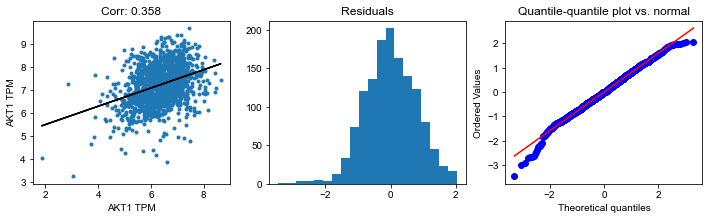

In [33]:
res1 = scatter(ccle_df, 'AKT1', ccle_df['BAX'], 'AKT1 TPM', bins=20)

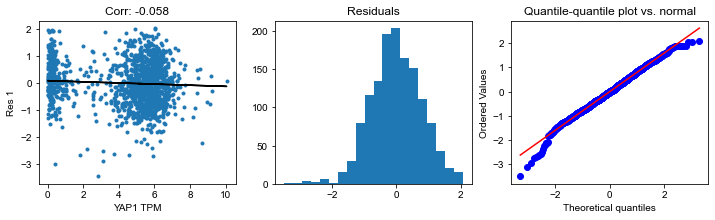

In [34]:
res2 = scatter(ccle_df, 'YAP1', res1, 'Res 1', bins=20)

Next steps:
1. load the INDRA SIF statement file
2. tabulate explanations for correlations;
3. predict correlations from graph structure, edge properties

In [35]:
sorted(corrs_for_genes(['KIRREL1'], df=expr_corr), 
       key=lambda x: x[2], reverse=True)

[]

# Paper Figures

In [36]:
opath = '/Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism' \
        '/bioexp_paper/output'
prefix = 'fig6_ipynb'

def fig_path(name, fmt):
    return join(opath, f'{prefix}_{name}.{fmt}')

## Figure: Example correlation

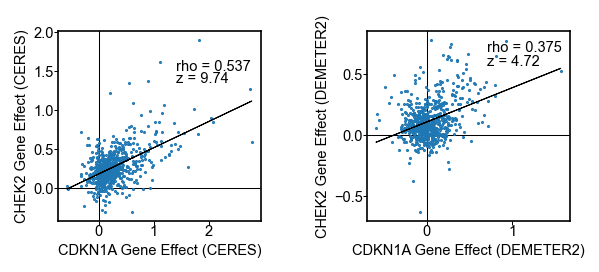

In [38]:
def plot_example(geneA, geneB):
    lw = 0.5
    ms = 1
    fig = plt.figure(figsize=(4, 2), dpi=150)
    
    # CRISPR plot
    plt.subplot(1, 2, 1)
    ax = plt.gca()
    # Axes lines
    ax.axhline(y=0, color='k', linewidth=lw)
    ax.axvline(x=0, color='k', linewidth=lw)
    plt.plot(crispr_df[geneA].values, crispr_df[geneB].values, marker='.', markersize=ms, linestyle='')
    
    # Plot linear regression
    crispr_lr = linregress(crispr_df[geneA].values, crispr_df[geneB].values)
    plt.plot(crispr_df[geneA].values, crispr_df[geneA].values * crispr_lr.slope + crispr_lr.intercept,
             linestyle='-', linewidth=lw, color='black')
    plt.xlabel(f'{geneA} Gene Effect (CERES)')
    plt.ylabel(f'{geneB} Gene Effect (CERES)')
    ax.text(1.4, 1.5, 'rho = %0.3f' % crispr_lr.rvalue, fontsize=pf.fontsize)
    ax.text(1.4, 1.35, 'z = %0.2f' % crispr_z[geneA][geneB], fontsize=pf.fontsize)
    pf.format_axis(ax)

    # RNAi plot
    plt.subplot(1, 2, 2)
    rnai_df_filt = rnai_df[~pd.isnull(rnai_df[geneA]) & ~pd.isnull(rnai_df[geneB])]
    ax = plt.gca()
    ax.axhline(y=0, color='k', linewidth=lw)
    ax.axvline(x=0, color='k', linewidth=lw)
    plt.plot(rnai_df_filt[geneA].values, rnai_df_filt[geneB].values, marker='.', markersize=ms, linestyle='')
    
    # Plot linear regression
    rnai_lr = linregress(rnai_df_filt[geneA].values, rnai_df_filt[geneB].values)
    plt.plot(rnai_df_filt[geneA].values, rnai_df_filt[geneA].values * rnai_lr.slope + rnai_lr.intercept,
             linestyle='-', linewidth=lw, color='black')
    plt.xlabel(f'{geneA} Gene Effect (DEMETER2)')
    plt.ylabel(f'{geneB} Gene Effect (DEMETER2)')
    ax.text(0.7, 0.69, 'rho = %0.3f' % rnai_lr.rvalue, fontsize=pf.fontsize)
    ax.text(0.7, 0.57, 'z = %0.2f' % rnai_z[geneA][geneB], fontsize=pf.fontsize)
    fig.tight_layout()
    pf.format_axis(ax)
    plt.savefig(fig_path(f'{geneA}_{geneB}_corr_plot', 'pdf'))
    
plot_example('CDKN1A', 'CHEK2')

## Figure: Proportion of correlations between mito genes

In [39]:
#mitocarta = pd.read_excel('data/Human.MitoCarta2.0.xls', sheet_name=1)
mitocarta = pd.read_excel('data/Human.MitoCarta3.0.xls', sheet_name=1)
mitogenes = list(mitocarta.Symbol.values)

In [43]:
mito2_pcts = []
mito1_pcts = []
corr_range = np.linspace(0, 6, 13)

In [44]:
corr_range

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ])

In [45]:
def get_mito_pairs():
    results = {}
    for ix in range(len(corr_range)):
        mito2_pairs = []
        mito1_pairs = []
        mito0_pairs = []
        corr_lb = corr_range[ix]
        corr_ub = None if (ix + 1) >= len(corr_range) \
                       else corr_range[ix + 1]
        print(f"Getting correlations between {corr_lb} and {corr_ub}")
        if corr_ub is None:
            z_range = dep_z[(dep_z.abs() >= corr_lb)]
        else:
            z_range = dep_z[(dep_z.abs() >= corr_lb) & (dep_z.abs() < corr_ub)]
        pair_iter = corr_matrix_to_generator(z_range, max_pairs=1000000)
        print("Looping correlations")
        for (a, b), zsc in pair_iter:
            # At least 1 mitogene
            if (a in mitogenes) or (b in mitogenes):
                mito1_pairs.append((a, b, zsc))
                # 2 mitogenes
                if (a in mitogenes) and (b in mitogenes):
                    mito2_pairs.append((a, b, zsc))
            # No mitogenes
            else:
                mito0_pairs.append((a, b, zsc))
        results[(corr_lb, corr_ub)] = {'mito0': mito0_pairs,
                                       'mito1': mito1_pairs,
                                       'mito2': mito2_pairs}
    return results

mito_res = get_mito_pairs()

Getting correlations between 0.0 and 0.5


INFO: [2021-03-23 09:02:19] depmap_analysis.network_functions.depmap_network_functions - Shuffling correlation matrix...


Looping correlations
Getting correlations between 0.5 and 1.0


INFO: [2021-03-23 09:05:15] depmap_analysis.network_functions.depmap_network_functions - Shuffling correlation matrix...


Looping correlations
Getting correlations between 1.0 and 1.5


INFO: [2021-03-23 09:07:23] depmap_analysis.network_functions.depmap_network_functions - Shuffling correlation matrix...


Looping correlations
Getting correlations between 1.5 and 2.0


INFO: [2021-03-23 09:09:00] depmap_analysis.network_functions.depmap_network_functions - Shuffling correlation matrix...


Looping correlations
Getting correlations between 2.0 and 2.5


INFO: [2021-03-23 09:10:59] depmap_analysis.network_functions.depmap_network_functions - Shuffling correlation matrix...


Looping correlations
Getting correlations between 2.5 and 3.0


INFO: [2021-03-23 09:12:47] depmap_analysis.network_functions.depmap_network_functions - Shuffling correlation matrix...


Looping correlations
Getting correlations between 3.0 and 3.5


INFO: [2021-03-23 09:14:06] depmap_analysis.network_functions.depmap_network_functions - Shuffling correlation matrix...


Looping correlations
Getting correlations between 3.5 and 4.0


INFO: [2021-03-23 09:15:05] depmap_analysis.network_functions.depmap_network_functions - Shuffling correlation matrix...


Looping correlations
Getting correlations between 4.0 and 4.5


INFO: [2021-03-23 09:16:01] depmap_analysis.network_functions.depmap_network_functions - Shuffling correlation matrix...


Looping correlations
Getting correlations between 4.5 and 5.0


INFO: [2021-03-23 09:16:58] depmap_analysis.network_functions.depmap_network_functions - Shuffling correlation matrix...


Looping correlations
Getting correlations between 5.0 and 5.5


INFO: [2021-03-23 09:17:55] depmap_analysis.network_functions.depmap_network_functions - Shuffling correlation matrix...


Looping correlations
Getting correlations between 5.5 and 6.0


INFO: [2021-03-23 09:18:52] depmap_analysis.network_functions.depmap_network_functions - Shuffling correlation matrix...


Looping correlations
Getting correlations between 6.0 and None


INFO: [2021-03-23 09:19:34] depmap_analysis.network_functions.depmap_network_functions - Shuffling correlation matrix...


Looping correlations


In [48]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

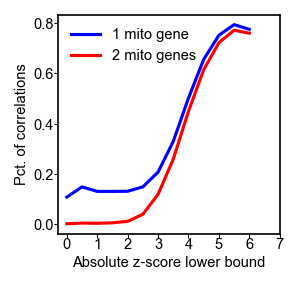

In [47]:
def plot_mito_pcts(mito_res):
    m1_vals = []
    m2_vals = []
    lbs_vals = []
    for corr_bounds, pair_dict in mito_res.items():
        # Use the lower bound
        lbs_vals.append(corr_bounds[0])
        num_mito0 = len(pair_dict['mito0'])
        num_mito1 = len(pair_dict['mito1'])
        num_mito2 = len(pair_dict['mito2'])
        total_corrs = num_mito0 + num_mito1
        m1_vals.append(num_mito1 / total_corrs)
        m2_vals.append(num_mito2 / total_corrs)
        
    plt.figure(figsize=(2, 2), dpi=150)
    plt.plot(lbs_vals, m1_vals, color='b', label='1 mito gene')
    plt.plot(lbs_vals, m2_vals, color='r', label='2 mito genes')
    ax = plt.gca()
    plt.xlabel('Absolute z-score lower bound')
    plt.ylabel('Pct. of correlations')
    plt.xticks(range(8))
    plt.legend(loc='upper left', fontsize=pf.fontsize, frameon=False)
    plt.subplots_adjust(left=0.16, bottom=0.15)
    pf.format_axis(ax)
    plt.savefig(fig_path(f'mito_corr_pcts', '.pdf'))
    
plot_mito_pcts(mito_res)   

## Hunting for other mitogenes

In [139]:
def nonmito(cutoff):
    nonmito_corrs = []
    for (corr_lb, corr_ub), pairs_dict in mito_res.items():
        mito1 = set(pairs_dict['mito1'])
        mito2 = set(pairs_dict['mito2'])
        only1 = mito1.difference(mito2)
        for a, b, zsc in only1:
            if abs(zsc) < 2:
                continue
            if a in mitogenes:
                mitogene = a
                nonmitogene = b
            else:
                mitogene = b
                nonmitogene = a
            nonmito_corrs.append((nonmitogene, mitogene, zsc))
    nonmito_df = pd.DataFrame.from_records(nonmito_corrs, columns=['non_mito', 'mito', 'z_score'])
    # Skips correlations involving only mito genes
    # Find correlations with 1 mitogene
    return nonmito_df
nonmito_df3 = nonmito(3.0)
gb = nonmito_df3.groupby('non_mito')
mito_agg_mean = gb.aggregate(lambda x: x.abs().mean()).sort_values(by='z_score', ascending=False)
mito_agg_mean[0:50]

,z_score
non_mito,
KIAA0391,4.082677
GTPBP8,3.693932
TFRC,3.644479
ADSS,3.607390
PEX6,3.469976
GART,3.466766
ADSL,3.455003
PPAT,3.392008
KCNK13,3.359146


Based on this analysis, MRPL58, and MCL1, TWNK (Twinkle mtDNA helicase), GATB (Glutamyl-TRNA(Gln) Amidotransferase Subunit B, Mitochondrial), MRM2 (Mitochondrial RRNA Methyltransferase 2), should definitely be included in mitocarta.

COL4A3BP is a ceramide transporter/sphingolipid metabolism regulator, linked to SPTLC2 (sphingolipid metabolism, in Mitocarta). possible interesting link to mitos.

WDR44 and ACAP2 both associated with endosomes/endocytic recycling. WDR44 also linked to iron uptake. Possible link to endosome/mitochondria relationship (which also involves iron). Interestingly, WDR44 is negatively correlated with many mitochondria ribosome subunits.

Weirdly, WDR44 is in this dataset because of strong correlation with KIAA0100, which is listed as a mitochondrila gene? And ACAP2 included because linked to RAB35 (apparently mitochondrial).  Need to understand more about this.

Iron transporter: GTPBP8 (ferrous iron transmembrane transporter activity), TFRC

Nucleotide biosynthesis genes: ADSS (purine), GART (purine), PPAT (purine), ADSL (purine), PFAS (purine), UMPS (pyrimidine).

Peroxisome:
* PEX6. Peroxisomal biogenesis. Correlated with ACOX1 and HSD17B4, both in MitoCarta and with peroxisomal function annotations. Binds CERS2 (ceramide synthase), MARCH5.
* PEX5, PEX12.

Other known:
* MCL1

Mysterious:
* LSM12. Binds PBP1 (stress granules, mRNA processing) and ATXN2, which is classified as a mitochondrial gene in Mitocarta (Genecards: "The encoded cytoplasmic protein localizes to the endoplasmic reticulum and plasma membrane, is involved in endocytosis, and modulates mTOR signals, modifying ribosomal translation and mitochondrial function."). In Yeast, binds a bunch of RNA processing and ribosome proteins (https://thebiogrid.org/36554/summary/saccharomyces-cerevisiae/lsm12.html).
* TAX1BP1. Correlated with NCOA4, androgen receptor coactivator classified as mitochondrial?
* ZNF638. Correlated with TNFRSF10B (DR5), CFLAR, CASP8, BCL2L1 (Bcl-XL).

Now let's aggregate by number of correlations (above cutoff) to see what comes up:

In [141]:
nonmito_df3[nonmito_df3.non_mito == 'TNFRSF10B']

,non_mito,mito,z_score
15075,TNFRSF10B,GATB,-2.403660
84406,TNFRSF10B,VDAC3,2.787408
89842,TNFRSF10B,CASP8,4.032860


In [142]:
nonmito_df3 = nonmito(3.0)
gb = nonmito_df3.groupby('non_mito')
mito_agg_mean = gb.aggregate('count').sort_values(by='z_score', ascending=False)
mito_agg_mean[0:50]

,mito,z_score
non_mito,,
KIAA0391,237,237
GTPBP8,237,237
TMEM242,193,193
CLUH,157,157
IL17D,122,122
MINOS1,106,106
RNASE13,103,103
ACTR3,101,101
HMBS,100,100


Of these, some should be in Mitocarta:
* KIAA0391 ("Mitochondrial Ribonuclease P Catalytic Subunit")
* CLUH (Clustered Mitochondria Homolog)
* MINOS1 (Mitochondrial Contact Site And Cristae Organizing System Subunit 10)

Other:
* GTPBP8 (iron)

In [88]:
'RHEBL1' in mitogenes

False

In [79]:
pd.DataFrame.from_records(nonmito_corrs[0:3], columns=['a', 'b', 'zsc'])

,a,b,zsc
0,URB1,NDUFA12,-0.084912
1,MAPK8,NDUFS4,0.103158
2,SP8,MTHFD2,-0.353901


## Figure: For Mitogenes, strong correlations != stronger effects

In [51]:
crispr_mean = crispr_df.abs().mean(axis=0).sort_values()

In [52]:
crispr_z_mean = crispr_z.abs().mean(axis=0)

In [54]:
n_corrs = 50
np.mean(sorted(crispr_z['CHEK2'].abs(), reverse=True)[1:n_corrs+1])

5.981479454112239

In [46]:
#crispr_z_mean = crispr_z.apply(lambda x: np.mean(sorted(x.abs(), reverse=True)[1:101]), axis=1)

In [55]:
crispr_z_mean.CHEK2

1.072579625463545

In [56]:
effect_corr = pd.concat([crispr_mean, crispr_z_mean], axis=1, sort=False)

In [57]:
mito_effect = effect_corr[effect_corr.index.isin(mitogenes)]
nonmito_effect = effect_corr[~effect_corr.index.isin(mitogenes)]

In [58]:
crispr_mean

CLDN24    0.062381
HBG1      0.064848
ADAD1     0.067826
OR4E2     0.070479
NLRP4     0.070744
            ...   
BUB3      2.049168
UBA1      2.066429
PSMB3     2.094563
HSPE1     2.137991
RAN       2.347276
Length: 18119, dtype: float64

In [59]:
res = nonmito_effect.groupby(pd.qcut(nonmito_effect[0].values, n_corrs)).mean()

<IPython.core.display.Javascript object>


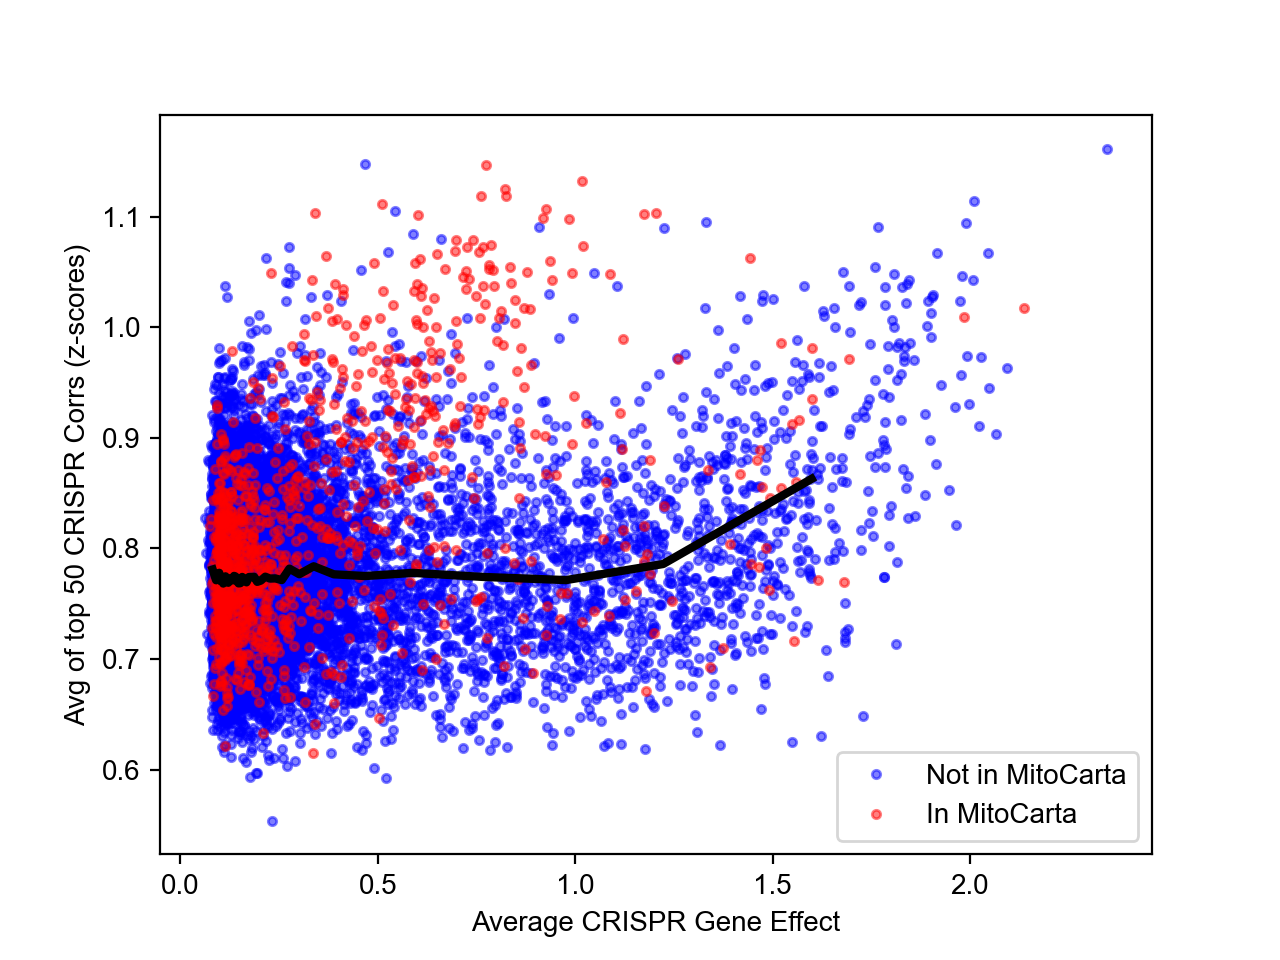

In [60]:
plt.plot(nonmito_effect[0], nonmito_effect[1], linestyle='', marker='.', color='b', alpha=0.5, label='Not in MitoCarta')
plt.plot(mito_effect[0], mito_effect[1], linestyle='', marker='.', color='r', alpha=0.5, label='In MitoCarta')
plt.plot(res[0].values, res[1].values, linewidth=3, color='black')
plt.xlabel('Average CRISPR Gene Effect')
plt.ylabel(f'Avg of top {n_corrs} CRISPR Corrs (z-scores)')
plt.legend()

## Load Solute Carrier Family genes

In [34]:
slc_df = pd.read_csv('data/slc_genes.csv')

In [35]:
slc_genes = list(slc_df['Approved symbol'].values)

In [36]:
#inet_file = '/Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research' \
#            '/Big Mechanism/datasets/depmap_analysis/graphs/2021-01-06/indranet_dir_graph.pkl'
#with open(inet_file, 'rb') as f:
#    inet = pickle.load(f)

In [37]:
# Load reactome dict
reactome_file = '/Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/' \
                'datasets/depmap_analysis/reactome_pathways.pkl'

apriori_mapping = get_mitocarta_info(mito_file)

with open(reactome_file, 'rb') as f:
    up2path, _, pathid2pathname = pickle.load(f)
    
reactome_dict = {'uniprot_mapping': up2path,
                 'pathid_name_mapping': pathid2pathname}

expl_funcs=['apriori_explained', 'expl_ab', 'expl_ba', 'expl_axb',
            'expl_bxa', 'find_cp', 'get_st', 'common_reactome_paths']

sd_range = (2, None)
dme_file = 'slc_explainer.pkl'

In [45]:
run_depmap(inet_file, z_filepath, dme_file, 'unsigned', sd_range, subset_list=slc_genes,
           overwrite=True, reactome_path=reactome_file,
           depmap_date='21q1', expl_funcs=expl_funcs, apriori_explained=mito_file, n_chunks=4)

INFO: [2021-03-04 17:01:38] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/graphs/2021-01-06/indranet_dir_graph.pkl
INFO: [2021-03-04 17:03:53] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2021-03-04 17:03:55] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2021-03-04 17:04:02] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2021-03-04 17:04:02] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2021-03-04 17:04:02] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 2+ SD
INFO: [2021-03-04 17:04:44] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2021-03-04 17:04:44] depmap_analysis

Execution time: 101.17000389099121 seconds
Done at 17:06:35


INFO: [2021-03-04 17:06:35] depmap_analysis.scripts.depmap_script2 - Dumping results to slc_explainer.pkl
INFO: [2021-03-04 17:06:35] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/depmap_analysis/notebooks/slc_explainer.pkl
INFO: [2021-03-04 17:06:36] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2021-03-04 17:06:36] depmap_analysis.scripts.depmap_script2 - Script finished


Explanation           count
-----------           -----
not_in_graph:         466
explained:            18080
apriori_explained:    6568
a_b:                  138
b_a:                  160
a_x_b:                10954
b_x_a:                11179
common_parent:        0
shared_target:        13017
reactome_paths:       113
total checked:        26834
unexplained:          8288
complex or direct:    186
x intermediate:       13439
explained no reactome, direct, apriori: 11341



In [46]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

In [47]:
with open(dme_file, 'rb') as f:
    dme = pickle.load(f)

In [57]:
dme_pair = dme.stats_df.set_index('pair').drop(['agA', 'agB', 'z_score'], axis=1)
dme_df = dme.expl_df.join(dme_pair, on='pair')

In [74]:
slc_to_expl = dme_df[(dme_df['z_score'] > 3) &
                     (dme_df['apriori_explained'] == False) &
                     (dme_df['reactome_paths'] == False)]

In [62]:
#axb_df = dme.get_filtered_triples_df()
dme.get_filtered_triples_df?

In [72]:
dme_axb = dme.stats_df.set_index('pair').drop(['agA', 'agB', 'z_score', 'agA_ns', 'agA_id', 'agB_ns', 'agB_id'], axis=1)
axb_all = axb_df.join(dme_axb, on='pair')
axb_all['avg_x_corr'] = (axb_all.ax_corr.abs() + axb_all.bx_corr.abs()) / 2

In [75]:
axb_all

,pair,agA,agB,z_score,agA_ns,agA_id,agB_ns,agB_id,expl_type,agX,...,explained,apriori_explained,a_b,b_a,a_x_b,b_x_a,common_parent,shared_target,reactome_paths,avg_x_corr
0,SLCO1A2_AGR3,SLCO1A2,AGR3,2.030604,HGNC,10956,HGNC,24167,a_x_b,ESR1,...,True,False,False,False,True,True,False,True,False,0.230532
1,SLCO1A2_AGR3,SLCO1A2,AGR3,2.030604,HGNC,10956,HGNC,24167,shared_target,ESR1,...,True,False,False,False,True,True,False,True,False,0.230532
2,SLCO1A2_CAVIN4,SLCO1A2,CAVIN4,2.253356,HGNC,10956,HGNC,33742,a_x_b,IL1B,...,True,False,False,False,True,True,False,True,False,0.213667
3,SLCO1A2_IFI35,SLCO1A2,IFI35,-2.014672,HGNC,10956,HGNC,5399,a_x_b,IFNG,...,True,False,False,False,True,True,False,True,False,0.289411
4,SLCO1A2_IFI35,SLCO1A2,IFI35,-2.014672,HGNC,10956,HGNC,5399,b_x_a,TNF,...,True,False,False,False,True,True,False,True,False,1.015793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60584,MPDU1_ZBTB38,MPDU1,ZBTB38,2.401479,HGNC,7207,HGNC,26636,shared_target,RPS3A,...,True,False,False,False,True,True,False,True,False,0.559068
60585,MPDU1_ZNF32,MPDU1,ZNF32,-2.059103,HGNC,7207,HGNC,13095,b_x_a,SP1,...,True,False,False,False,False,True,False,False,False,0.985993
60586,MPDU1_ZNF343,MPDU1,ZNF343,-2.215359,HGNC,7207,HGNC,16017,a_x_b,MOV10,...,True,False,False,False,True,True,False,True,False,0.562623
60587,MPDU1_ZNF343,MPDU1,ZNF343,-2.215359,HGNC,7207,HGNC,16017,b_x_a,MOV10,...,True,False,False,False,True,True,False,True,False,0.562623


In [76]:
slc_to_expl = axb_all[(axb_all['z_score'] > 3) &
                         (axb_all['apriori_explained'] == False) &
                         (axb_all['reactome_paths'] == False)]

In [ ]:
slc_to_expl[slc_to_expl['agA'] ==]

In [90]:
slc_to_expl[slc_to_expl['avg_x_corr'] > 1.5].sort_values('avg_x_corr', ascending=False)

,pair,agA,agB,z_score,agA_ns,agA_id,agB_ns,agB_id,expl_type,agX,...,explained,apriori_explained,a_b,b_a,a_x_b,b_x_a,common_parent,shared_target,reactome_paths,avg_x_corr
17490,SLC7A1_CAD,SLC7A1,CAD,4.075458,HGNC,11057,HGNC,1424,shared_target,SDHA,...,True,False,False,False,True,True,False,True,False,4.078141
6747,SLC2A4_TNFSF13,SLC2A4,TNFSF13,3.369814,HGNC,11009,HGNC,11928,b_x_a,TNFSF12,...,True,False,False,False,True,True,False,True,False,3.974827
28995,SLC11A2_FCHO2,SLC11A2,FCHO2,3.351584,HGNC,10908,HGNC,25180,shared_target,TFRC,...,True,False,False,False,False,True,False,True,False,3.623181
28993,SLC11A2_FCHO2,SLC11A2,FCHO2,3.351584,HGNC,10908,HGNC,25180,b_x_a,TFRC,...,True,False,False,False,False,True,False,True,False,3.623181
55117,SLC39A13_MLC1,SLC39A13,MLC1,3.117003,HGNC,20859,HGNC,17082,shared_target,INS,...,True,False,False,False,True,True,False,True,False,3.335783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20181,SLC7A5_PPAT,SLC7A5,PPAT,3.160986,HGNC,11063,HGNC,9238,a_x_b,TP53,...,True,False,False,False,True,True,False,True,False,1.521894
53138,SLC39A7_ARPC2,SLC39A7,ARPC2,3.331963,HGNC,4927,HGNC,705,b_x_a,EGFR,...,True,False,False,False,True,True,False,True,False,1.517176
53141,SLC39A7_ARPC2,SLC39A7,ARPC2,3.331963,HGNC,4927,HGNC,705,shared_target,EGFR,...,True,False,False,False,True,True,False,True,False,1.517176
12865,SLC5A7_UGGT1,SLC5A7,UGGT1,3.019890,HGNC,14025,HGNC,15663,shared_target,HSPA5,...,True,False,False,False,True,True,False,True,False,1.507418


In [52]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

In [85]:
dme.plot_corr_stats('slc_output', z_corr=dep_z)

INFO: [2021-03-08 16:18:43] depmap_analysis.util.statistics - Generating corr stats data
INFO: [2021-03-08 16:18:43] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2021-03-08 16:18:43] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2021-03-08 16:18:43] depmap_analysis.scripts.corr_stats_axb - Filter expl_df to pathway, direct, shared_target
INFO: [2021-03-08 16:18:43] depmap_analysis.scripts.corr_stats_axb - Getting axb subj-obj pairs through multiprocessing
INFO: [2021-03-08 16:18:43] depmap_analysis.scripts.corr_stats_async - Stratifying correlations by interaction type
INFO: [2021-03-08 16:18:43] depmap_analysis.scripts.corr_stats_async - Starting workers for pairs at 16:18:43 with 25188 pairs to check
INFO: [2021-03-08 16:18:43] depmap_analysis.scripts.corr_stats_async - Down sampling ab_corr_pairs to 10000
INFO: 

INFO: [2021-03-08 16:26:50] depmap_analysis.scripts.corr_stats_async - Assembling 12 results
INFO: [2021-03-08 16:27:43] depmap_analysis.util.statistics - Using file name all_x_corrs_unsigned.pdf
INFO: [2021-03-08 16:27:46] depmap_analysis.util.statistics - Using file name avg_x_corrs_unsigned.pdf
INFO: [2021-03-08 16:27:47] depmap_analysis.util.statistics - Using file name top_x_corrs_unsigned.pdf
INFO: [2021-03-08 16:27:47] depmap_analysis.util.statistics - Using file name all_azb_corrs_unsigned.pdf
INFO: [2021-03-08 16:29:22] depmap_analysis.util.statistics - Using file name azb_avg_corrs_unsigned.pdf
INFO: [2021-03-08 16:29:58] depmap_analysis.util.statistics - Using file name all_azfb_corrs_unsigned.pdf
INFO: [2021-03-08 16:30:51] depmap_analysis.util.statistics - Using file name azfb_avg_corrs_unsigned.pdf
INFO: [2021-03-08 16:31:21] depmap_analysis.util.statistics - Using file name all_reactome_corrs_unsigned.pdf
INFO: [2021-03-08 16:31:22] depmap_analysis.util.statistics - Usin

In [87]:
dme.plot_dists('slc_output', z_corr=dep_z)

INFO: [2021-03-08 16:40:56] depmap_analysis.util.statistics - Data already present in corr_stats_axb


In [88]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

In [82]:
gene = 'SLC2A4'
gene_df = slc_to_expl[(slc_to_expl['agA'] == gene) | (slc_to_expl['agB'] == gene)]
expl_set = []
for row in gene_df.itertuples():
    if row.expl_type == 'shared_regulator':
        continue
    elif row.expl_type == 'shared_target':
        expl_data = row.expl_data[2]
    else:
        expl_data = row.expl_data
    for expl in expl_data:
        expl_set.append(expl)
expl_ctr = Counter(expl_set)
expl_ctr = sorted([(k, v) for k, v in expl_ctr.items()], key=lambda x: x[1], reverse=True)

AttributeError: 'Pandas' object has no attribute 'expl_data'

In [84]:
gene_df[0:50]

,pair,agA,agB,z_score,agA_ns,agA_id,agB_ns,agB_id,expl_type,agX,...,explained,apriori_explained,a_b,b_a,a_x_b,b_x_a,common_parent,shared_target,reactome_paths,avg_x_corr
5577,SLC2A4_BCL6B,SLC2A4,BCL6B,3.027911,HGNC,11009,HGNC,1002,a_x_b,MYOD1,...,True,False,False,False,True,True,False,True,False,0.537159
5578,SLC2A4_BCL6B,SLC2A4,BCL6B,3.027911,HGNC,11009,HGNC,1002,a_x_b,RELA,...,True,False,False,False,True,True,False,True,False,0.790346
5579,SLC2A4_BCL6B,SLC2A4,BCL6B,3.027911,HGNC,11009,HGNC,1002,a_x_b,SREBF1,...,True,False,False,False,True,True,False,True,False,0.185907
5580,SLC2A4_BCL6B,SLC2A4,BCL6B,3.027911,HGNC,11009,HGNC,1002,a_x_b,SP1,...,True,False,False,False,True,True,False,True,False,0.345830
5581,SLC2A4_BCL6B,SLC2A4,BCL6B,3.027911,HGNC,11009,HGNC,1002,b_x_a,CXXC1,...,True,False,False,False,True,True,False,True,False,0.455553
5582,SLC2A4_BCL6B,SLC2A4,BCL6B,3.027911,HGNC,11009,HGNC,1002,b_x_a,TP53,...,True,False,False,False,True,True,False,True,False,1.661719
5583,SLC2A4_BCL6B,SLC2A4,BCL6B,3.027911,HGNC,11009,HGNC,1002,b_x_a,HGF,...,True,False,False,False,True,True,False,True,False,0.768909
5584,SLC2A4_BCL6B,SLC2A4,BCL6B,3.027911,HGNC,11009,HGNC,1002,b_x_a,GOLGA2,...,True,False,False,False,True,True,False,True,False,0.323861
5585,SLC2A4_BCL6B,SLC2A4,BCL6B,3.027911,HGNC,11009,HGNC,1002,shared_target,CXXC1,...,True,False,False,False,True,True,False,True,False,0.455553
5586,SLC2A4_BCL6B,SLC2A4,BCL6B,3.027911,HGNC,11009,HGNC,1002,shared_target,TP53,...,True,False,False,False,True,True,False,True,False,1.661719


## Other

In [ ]:
from indra.util import batch_iter

In [ ]:
goi = 'MDM2'
res = sort_corrs(dep_z, goi)
#for r in res[0:20]:
#    print(r)
expl_pct = []
batch_size = 1000
for batch in batch_iter(res, batch_size):
    counter = 0
    for gene, corr in batch:
        if gene in indra_dg[goi]:
            counter += 1
    pct = 100 * (counter / batch_size)
    expl_pct.append(pct)

In [ ]:
plt.figure()
plt.bar(range(len(expl_pct)), expl_pct)

# Drug-Drug Correlations

In [ ]:
drug2_corrs = drug_resp_df.corr()

In [ ]:
from indra.sources import tas
tp = tas.process_from_web()

In [ ]:
tas_stmts = tp.statements

In [ ]:
# Build up a dictionary of mappings from CHEBI to SMILES and INCHIKEY
import pyobo
chebi_inchikey_property = 'http://purl.obolibrary.org/obo/chebi/inchikey'
chebi_smiles_property = 'http://purl.obolibrary.org/obo/chebi/smiles'
chebi_id_to_smiles = pyobo.get_filtered_properties_mapping('chebi', chebi_smiles_property)
chebi_id_to_inchikey = pyobo.get_filtered_properties_mapping('chebi', chebi_inchikey_property)

In [ ]:
foo = [stmt for stmt in tas_stmts if stmt.agent_list()[0].name == 'vemurafenib']

In [ ]:
foo[0]

In [ ]:
foo[0].subj.db_refs

In [ ]:
chembl_ids = [stmt.agent_list()[0].db_refs.get('CHEMBL') for stmt in tas_stmts]
chembl_ids = list(set([i for i in chembl_ids if i]))

In [ ]:
len(chembl_ids)

In [ ]:
chembl_ids_str = ';'.join(chembl_ids[0:200])

In [ ]:
j = res.json()

In [ ]:
j['molecules'][0]['molecule_chembl_id']

In [ ]:
import requests
from indra.util import batch_iter
batch_size = 200
chembl_url = 'https://www.ebi.ac.uk/chembl/api/data/molecule/set/'
inchi_keys = []
for ix, batch in enumerate(batch_iter(chembl_ids, batch_size)):
    chembl_ids_str = ';'.join(list(batch))
    print(ix)
    res = requests.get(chembl_url + chembl_ids_str, headers={'Accept': 'application/json'})
    if res.status_code != 200:
        print("Error occurred")
        break
    for mol in j['molecules']:
        cid = mol['molecule_chembl_id']
        ik = mol['molecule_structures']['standard_inchi_key']
        inchi_keys.append((cid, ik))

In [ ]:
j = res.json()

In [ ]:
inchi_to_chembl = {t[1]: t[0] for t in inchi_keys}
chembl_to_inchi = {t[0]: t[1] for t in inchi_keys}

In [ ]:
def get_drug_id(name):
    drug_rec = drug_info_df[drug_info_df.name == name]
    return drug_rec.index.to_list()[0]

def get_drug_name(drug_id):
    drug_rec = drug_info_df.loc[drug_id]
    return drug_rec['name']

def get_drug_targets(drug_id):
    drug_rec = drug_info_df.loc[drug_id]
    targets = drug_rec['target']
    if pd.isna(targets):
        return []
    else:
        return [t.strip() for t in targets.split(',')]

In [ ]:
# Dump all smiles strings from the DepMap data
depmap_smiles = set()
for _, smiles_str in drug_info_df.smiles.items():
    if pd.isna(smiles_str):
        continue
    for sm in smiles_str.split(','):
        sm = sm.strip()
        if sm:
            depmap_smiles.add(sm.strip())
            
depmap_smiles = list(demap_smiles)

with open('depmap_smiles.txt', 'wt') as f:
    for sm in depmap_smiles:
        f.write('%s\n' % sm)

In [ ]:
# Convert from SMILES to INCHIKEY using obabel:
# $ obabel -ismi depmap_smiles.txt -oinchikey > depmap_inchikey.txt

In [ ]:
# Now, read the INCHIKEY databack in and build up a mapping dictionary
depmap_inchikey = []
with open('depmap_inchikey.txt', 'rt') as f:
    depmap_inchikey = [l.strip() for l in f.readlines()]
depmap_smiles_to_ik = dict(zip(depmap_smiles, depmap_inchikey))

In [ ]:
import requests
from indra.util import batch_iter
chembl_url = 'https://www.ebi.ac.uk/chembl/api/data/substructure/'
dmik_to_chembl = {}
for ix, ik in enumerate(depmap_smiles_to_ik.values()):
    if ix > 10:
        break
    res = requests.get(chembl_url + ik, headers={'Accept': 'application/json'})
    if res.status_code != 200:
        print("Error occurred")
        break
    if res.json()['molecules']:
        for mol in res.json()['molecules']:
            cid = mol['molecule_chembl_id']
            if ik not in dmik_to_chembl:
                dmik_to_chembl[ik] = [cid]
            else:
                dmik_to_chembl[ik].append(cid)

In [ ]:
dmik_to_chembl

In [ ]:
drug_name = 'vemurafenib'

In [ ]:
drug_info_df[drug_info_df['name'] == 'vemurafenib']

In [ ]:
sm = [s.strip() for s in drug_info_df[drug_info_df['name'] == 'vemurafenib']['smiles'].values[0].split(',')]

In [ ]:
sm

In [ ]:
for s in sm:
    ik = depmap_smiles_to_ik[s]
    print(ik)

In [ ]:
chembl_to_inchi['CHEMBL1229517']

In [ ]:
drug_name = 'abemaciclib'
corrs = sort_corrs(drug2_corrs, get_drug_id(drug_name))
results = []
corr_k = 20
for i, (corr_drug_id, corr_val) in enumerate(corrs):
    if corr_val == 1.0:
        continue
    if i >= corr_k:
        break
    corr_drug_name = get_drug_name(corr_drug_id)
    corr_targets = get_drug_targets(corr_drug_id)
    for t in corr_targets:
        results.append((corr_drug_name, corr_drug_id, corr_val, t))
tgt_df = pd.DataFrame.from_records(results, columns=('drug_name', 'drug_id', 'corr', 'target'))

In [ ]:
tgt_df

In [ ]:
tgt_df

In [ ]:
tgt_corrs = tgt_df.groupby('target')['corr'].sum()
tgt_counts = tgt_df.groupby('target')['drug_id'].count()
tgt_corrs.sort_values(ascending=False, inplace=True)
tgt_counts.sort_values(ascending=False, inplace=True)

In [ ]:
num_tgts = 20
top_corrs = tgt_corrs[0:num_tgts]
labels = top_corrs.index.to_list()
corrs = top_corrs.values

In [ ]:
plt.figure()
plt.bar(range(len(corrs)), corrs, align='center', tick_label=labels)
plt.xticks(rotation='vertical')
plt.subplots_adjust(bottom=0.2)
plt.xlabel('Nominal targets of top %d correlates' % corr_k)
plt.ylabel('Count')
plt.title('Targets of drugs correlated with %s' % drug_name)
plt.show()

INFO: [2021-03-16 11:44:30] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:30] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:30] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:30] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:30] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:30] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:30] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: 

INFO: [2021-03-16 11:44:30] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:30] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:30] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:30] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:30] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:30] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:30] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: 

INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: 

7.230769994609354

INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: 

INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: [2021-03-16 11:44:31] matplotlib.texmanager - No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO: 

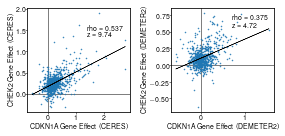

In [47]:
from indra.util import plot_formatting as pf
from scipy.stats import linregress

geneA = 'CDKN1A'
geneB = 'CHEK2'
lw = 0.5
ms = 1
fig = plt.figure(figsize=(4, 2))
# CRISPR plot
plt.subplot(1, 2, 1)
ax = plt.gca()
ax.axhline(y=0, color='k', linewidth=lw)
ax.axvline(x=0, color='k', linewidth=lw)
plt.plot(crispr_df[geneA].values, crispr_df[geneB].values, marker='.', markersize=ms, linestyle='')
# Plot linear regression
crispr_lr = linregress(crispr_df[geneA].values, crispr_df[geneB].values)
plt.plot(crispr_df[geneA].values, crispr_df[geneA].values * crispr_lr.slope + crispr_lr.intercept,
         linestyle='-', linewidth=lw, color='black')
plt.xlabel(f'{geneA} Gene Effect (CERES)')
plt.ylabel(f'{geneB} Gene Effect (CERES)')
ax.text(1.4, 1.5, 'rho = %0.3f' % crispr_lr.rvalue, fontsize=pf.fontsize)
ax.text(1.4, 1.35, 'z = %0.2f' % crispr_z[geneA][geneB], fontsize=pf.fontsize)
pf.format_axis(ax)
# RNAi plot
plt.subplot(1, 2, 2)
rnai_df_filt = rnai_df[~pd.isnull(rnai_df[geneA]) & ~pd.isnull(rnai_df[geneB])]
ax = plt.gca()
ax.axhline(y=0, color='k', linewidth=lw)
ax.axvline(x=0, color='k', linewidth=lw)
plt.plot(rnai_df_filt[geneA].values, rnai_df_filt[geneB].values, marker='.', markersize=ms, linestyle='')
# Plot linear regression
rnai_lr = linregress(rnai_df_filt[geneA].values, rnai_df_filt[geneB].values)
plt.plot(rnai_df_filt[geneA].values, rnai_df_filt[geneA].values * rnai_lr.slope + rnai_lr.intercept,
         linestyle='-', linewidth=lw, color='black')
plt.xlabel(f'{geneA} Gene Effect (DEMETER2)')
plt.ylabel(f'{geneB} Gene Effect (DEMETER2)')
ax.text(0.7, 0.69, 'rho = %0.3f' % rnai_lr.rvalue, fontsize=pf.fontsize)
ax.text(0.7, 0.57, 'z = %0.2f' % rnai_z[geneA][geneB], fontsize=pf.fontsize)

pf.format_axis(ax)
fig.tight_layout()
plt.savefig(join(figdir, f'{geneA}_{geneB}_corr_plot.pdf'))
dep_z[geneA][geneB]

# Deprecated/Old

## Load Cosmic Data

In [ ]:
cos_df = pd.read_csv('data/Census_allThu Jun 13 20_37_30 2019.csv')

In [ ]:
cos_df.head()

In [ ]:
cos_corrs = corrs_for_genes(cos_df['Gene Symbol'])

In [ ]:
dme

In [ ]:
5+5

In [ ]:
slc_df.head()
slc_corrs = corrs_for_genes(slc_df['Approved symbol'])

In [ ]:
slc_df

In [ ]:
mitocarta = pd.read_excel('data/Human.MitoCarta2.0.xls', sheet_name=1)
mitogenes = list(mitocarta.Symbol.values)

In [ ]:
'PNPT1' in mitogenes

In [ ]:
slc_corrs

In [ ]:
slc_corrs_filt = []
slc_corrs_seen = set()
for corr in slc_corrs:
    # Filter out correlations we've already seen
    corr_set = frozenset(corr)
    if corr_set in slc_corrs_seen:
        continue
    else:
        slc_corrs_seen.add(corr_set)
    # Filter out self-correlations
    if corr[0] == corr[1]:
        continue
    # Filter out mitochondrial gene correlations
    elif corr[0] in mitogenes or corr[1] in mitogenes:
        continue
    else:
        slc_corrs_filt.append(corr)

In [ ]:
slc_corrs_filt.sort(key=lambda x: x[2], reverse=True)

In [ ]:
slc_corrs_filt

In [ ]:
len(slc_corrs_filt)

In [ ]:
import csv
with open('slc_corrs_no_mito.csv', 'wt') as f:
    csv_writer = csv.writer(f, delimiter=',')
    csv_writer.writerows(slc_corrs_filt)

In [ ]:
import requests

In [ ]:
query = {'source': None,
         'target': None,
         'stmt_filter': ['conversion', 'fplx'],
         'node_filter': ['hgnc', 'fplx', 'chebi', 'pubchem', 'go', 'mesh'],
         'node_blacklist': [],
         'edge_hash_blacklist': [],
         'path_length': 1,
         'sign': 'no_sign',
         'weighted': False,
         'bsco': 0.,
         'direct_only': False,
         'curated_db_only': False,         
         'fplx_expand': False,
         'simple': False,
         'k_shortest': False}

def get_expl_corrs(gene_pairs):
    no_path = []
    has_2path = []
    has_3path = []
    for ix, (gene_a, gene_b, z_score) in enumerate(gene_pairs):
        for source, target in ((gene_a, gene_b), (gene_b, gene_a)):
            print("%d getting paths for %s, %s" % (ix, source, target))
            query['source'] = source
            query['target'] = target
            query['path_length'] = 1
            res = requests.post('http://127.0.0.1:5000/query/submit', json=query).json()
            if '2' in res['result']['paths_by_node_count']:
                has_2path.append((source, target, z_score))
            else:
                query['path_length'] = 2
                res = requests.post('http://127.0.0.1:5000/query/submit', json=query).json()
                if '3' in res['result']['paths_by_node_count']:
                    has_3path.append((source, target, z_score))                
                else:
                    no_path.append((source, target, z_score))
    return {'no_path': no_path, 'has_2path': has_2path, 'has_3path': has_3path}

In [ ]:
paths = get_expl_corrs(sorted(slc_corrs, key=lambda x: x[2], reverse=True))

In [ ]:
paths['has_2path']

In [ ]:
paths['has_3path']

In [ ]:
paths['no_path']

In [ ]:
query['source'] = 'GRSF1'
query['target'] = 'SLC30A9'
query['path_length'] = 2
res = requests.post('http://127.0.0.1:5000/query/submit', json=query).json()

In [ ]:
res

## Load INDRA SIF DB

In [ ]:
stmts_df = pd.read_csv('data/stmts_by_pair_type.csv')
# Filter to HGNC only
stmts_df = stmts_df[(stmts_df['agA_ns'] == 'HGNC') & (stmts_df['agB_ns'] == 'HGNC')]
# Remove namespace and identifier columns, leaving only name
stmts_df = stmts_df[['agA_name', 'agB_name', 'stmt_type', 'evidence_count']]
# Remove self-edges
stmts_df = stmts_df[stmts_df['agA_name'] != stmts_df['agB_name']]
# Useful bits of Pandas to know, ultimately not used here:
# pd.crosstab([foo['agA_name'], foo['agB_name']], foo['stmt_type'], foo['evidence_count'],
#             aggfunc='sum', dropna=False).fillna(0)
# baz = bar[bar.apply(lambda x: x.name[0] != x.name[1], axis=1)]

In [ ]:
x_dict = {}
for row in stmts_df.values:
    try:
        raw_corr = dep_z[row[0]][row[1]]
        """
        if int(raw_corr) == 0:
            corr = 0
        elif int(raw_corr) < 0:
            corr = -1
        elif int(raw_corr) > 0:
            corr = 1
        """
        corr = raw_corr
    except KeyError:
        continue
    stmt_type = row[2]
    gene_pair = (row[0], row[1])
    if gene_pair not in x_dict:
        x_dict[gene_pair] = {'Corr': corr}
    x_dict[gene_pair][stmt_type] = row[3]
features = ['Activation', 'Inhibition', 'Corr']
all_data = np.zeros((len(x_dict), len(features)))
for row_ix, feat_dict in enumerate(x_dict.values()):
    for feat_name, feat_val in feat_dict.items():
        if feat_name not in features:
            continue
        feat_ix = features.index(feat_name)
        all_data[row_ix, feat_ix] = feat_val

In [ ]:
"""
# Shuffle the matrix in place
np.random.shuffle(all_data)
# Balance the data
ctr = Counter(all_data[:, -1])
classes = sorted([(k, v) for k,  v in ctr.items()], key=lambda x: x[0])
# Get the class with the fewest members
min_class_count = min([t[1] for t in classes])
min_class_count
data_bal = np.zeros((min_class_count * len(classes), len(features)))
row_ix = 0
for one_class, count in classes:
    num_class_rows = 0
    for ix in range(all_data.shape[0]):
        if all_data[ix, -1] == one_class:
            data_bal[row_ix] = all_data[ix,:]
            row_ix += 1
            num_class_rows += 1
        if num_class_rows >= min_class_count:
            print("Finished class %s, at rows %s" % (one_class, row_ix))
            break

"""

In [ ]:
# Divide training and test
np.random.shuffle(all_data)
partition_ix = int(len(all_data) * 0.8)
train_data = all_data[0:partition_ix, :]
test_data = all_data[partition_ix:, :]
x_train = train_data[:,:-1]
y_train = train_data[:, -1]
x_test = test_data[:, :-1]
y_test = test_data[:, -1]

## Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train, y_train)
nb.score(x_test, y_test)

In [ ]:
yctr = Counter(y_train)
yclasses = sorted([(k, v) for k,  v in yctr.items()], key=lambda x: x[0])

In [ ]:
[features + ['Count']] + list(zip(nb.coef_, classes))

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from sklearn.kernel_ridge import KernelRidge
lr = LinearRegression()

In [ ]:
lr.fit(x_train, y_train)
lr.coef_

In [ ]:
y_pred = lr.predict(x_train)
explained_variance_score(y_train, y_pred)

In [ ]:
y_mean = np.full(y_train.shape, y_train.mean())
explained_variance_score(y_train, y_mean)

In [ ]:
y_pred_test = lr.predict(x_test)
explained_variance_score(y_test, y_pred_test)

## Load INDRA Statements (deprecated)

In [ ]:
reload = False
if reload:
    inc_stmts = ac.load_statements('increase_amt.pkl')
    dec_stmts = ac.load_statements('decrease_amt.pkl')
    stmts = inc_stmts + dec_stmts
    stmts = ac.map_grounding(stmts)
    stmts = [s for s in stmts if s.subj and s.subj.db_refs.get('HGNC')
                             and s.obj and s.obj.db_refs.get('HGNC')]
    stmts = ac.run_preassembly(stmts)
    ac.dump_statements(stmts, 'assembled_stmts.pkl')
else:
    stmts = ac.load_statements('assembled_stmts.pkl')

In [ ]:
stmts_by_obj = defaultdict(list)
for s in stmts:
    gene_id = s.obj.db_refs['HGNC']
    gene_name = hgnc_client.get_hgnc_name(gene_id)
    stmts_by_obj[gene_name].append(s)

In [ ]:
stmt_counts = []
for obj, stmts in stmts_by_obj.items():
    stmt_counts.append((obj, len(stmts)))
stmt_counts.sort(key=lambda x: x[1], reverse=True)

In [ ]:
stmt_counts[0:10]

In [ ]:
gene = 'BCL2'
rank = 0
stmts_by_obj[gene].sort(key=lambda s: s.belief, reverse=True)
print(stmts_by_obj[gene][rank], '\n')
print('\n'.join(['%d: %s\n' % (i, str((e.source_api, e.text)))
                 for i, e in enumerate(stmts_by_obj[gene][rank].evidence)]))